In [1]:
%%capture
!pip install --upgrade jax 
!pip install --upgrade jaxlib
!pip install git+git://github.com/deepmind/optax.git
!pip install flax

In [2]:
import os
if 'TPU_NAME' in os.environ:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1


    from jax.config import config
    config.FLAGS.jax_xla_backend = "tpu_driver"
    config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print('Registered TPU:', config.FLAGS.jax_backend_target)
else:
    print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Registered TPU: grpc://10.0.0.2:8470


In [3]:
import time
import jax
import flax
import jaxlib
import optax
from flax import linen as nn
from flax.training import train_state
import numpy as np
import jax.numpy as jnp
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds


2021-12-18 09:19:55.918857: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib


In [4]:
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [5]:
class AlexNet(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=64, kernel_size=(11, 11), strides=(4, 4), padding=((2, 2), (2, 2)))(x)
        x = nn.relu(x)
        x = nn.max_pool(x,window_shape=(3,3), strides=(2,2), padding=((0, 0), (0, 0)))
        x = nn.Conv(features=192, kernel_size=(5, 5), strides=(1, 1), padding=((2, 2), (2, 2)))(x)
        x = nn.relu(x)
        x = nn.max_pool(x,window_shape=(3,3), strides=(2,2), padding=((0, 0), (0, 0)))
        x = nn.Conv(features=384, kernel_size=(3, 3), strides=(1, 1), padding=((1, 1), (1, 1)))(x)
        x = nn.relu(x)
        x = nn.Conv(features=256, kernel_size=(3, 3), strides=(1, 1), padding=((1, 1), (1, 1)))(x)
        x = nn.relu(x)
        x = nn.Conv(features=256, kernel_size=(3, 3), strides=(1, 1), padding=((1, 1), (1, 1)))(x)
        x = nn.relu(x)
        x = nn.max_pool(x,window_shape=(3,3), strides=(2,2), padding=((0, 0), (0, 0)))
        x = nn.avg_pool(x, window_shape=(6, 6))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dropout(0.5, deterministic=True)(x)
        x = nn.Dense(features=4096)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5, deterministic=True)(x)
        x = nn.Dense(features=1024)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax (x)
        return x

In [6]:
def cross_entropy_loss(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [7]:
def compute_metrics(*, logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

In [8]:
def create_train_state(rng, learning_rate, momentum):
    """Creates initial `TrainState`."""
    model = AlexNet()
    params = model.init(rng, jnp.ones([32, 227, 227, 3]))['params']
    tx = optax.sgd(learning_rate, momentum)
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx)

In [9]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    def loss_fn(params):
        logits = AlexNet().apply({'params': params}, batch['image'])
        loss = cross_entropy_loss(logits=logits, labels=batch['label'])
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=batch['label'])
    return state, metrics

In [10]:
@jax.jit
def eval_step(params, batch):
    logits = AlexNet().apply({'params': params}, batch['image'])
    return compute_metrics(logits=logits, labels=batch['label'])

In [11]:
def eval_model(params, test_ds):
    metrics = eval_step(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

In [12]:
def train_epoch(state, train_ds, batch_size, epoch, rng, loss_trains, accuracy_trains):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        del batch['id']
        batch['image'] = jnp.float32(batch['image']) / 255.
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]}
    loss_trains.append(epoch_metrics_np['loss'])
    accuracy_trains.append(epoch_metrics_np['accuracy']*100)
    print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
        epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

    return state

In [13]:
def get_datasets():
    ds_builder = tfds.builder('cifar10')
    ds_builder.download_and_prepare()
    train_dsb = ds_builder.as_dataset(split='train', batch_size=-1)
    train_dsb['image']=tf.compat.v1.image.resize(train_dsb['image'], size=(227,227), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, align_corners=False,preserve_aspect_ratio=False, name=None)
    train_ds = tfds.as_numpy(train_dsb)
    del train_dsb

    test_dsb = ds_builder.as_dataset(split='test', batch_size=-1)
    test_dsb['image']=tf.compat.v1.image.resize(test_dsb['image'], size=(227,227), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, align_corners=False,preserve_aspect_ratio=False, name=None)
    test_ds = tfds.as_numpy(test_dsb)
    del test_dsb
  
    return train_ds, test_ds

In [14]:
train_ds, test_ds = get_datasets()
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.cs.toronto.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


0 examples [00:00, ? examples/s]

2021-12-18 09:20:18.201473: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-18 09:20:18.201577: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteRP9ASX/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteRP9ASX/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


2021-12-18 09:21:27.109352: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 7729350000 exceeds 10% of free system memory.
2021-12-18 09:22:26.483114: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1545870000 exceeds 10% of free system memory.


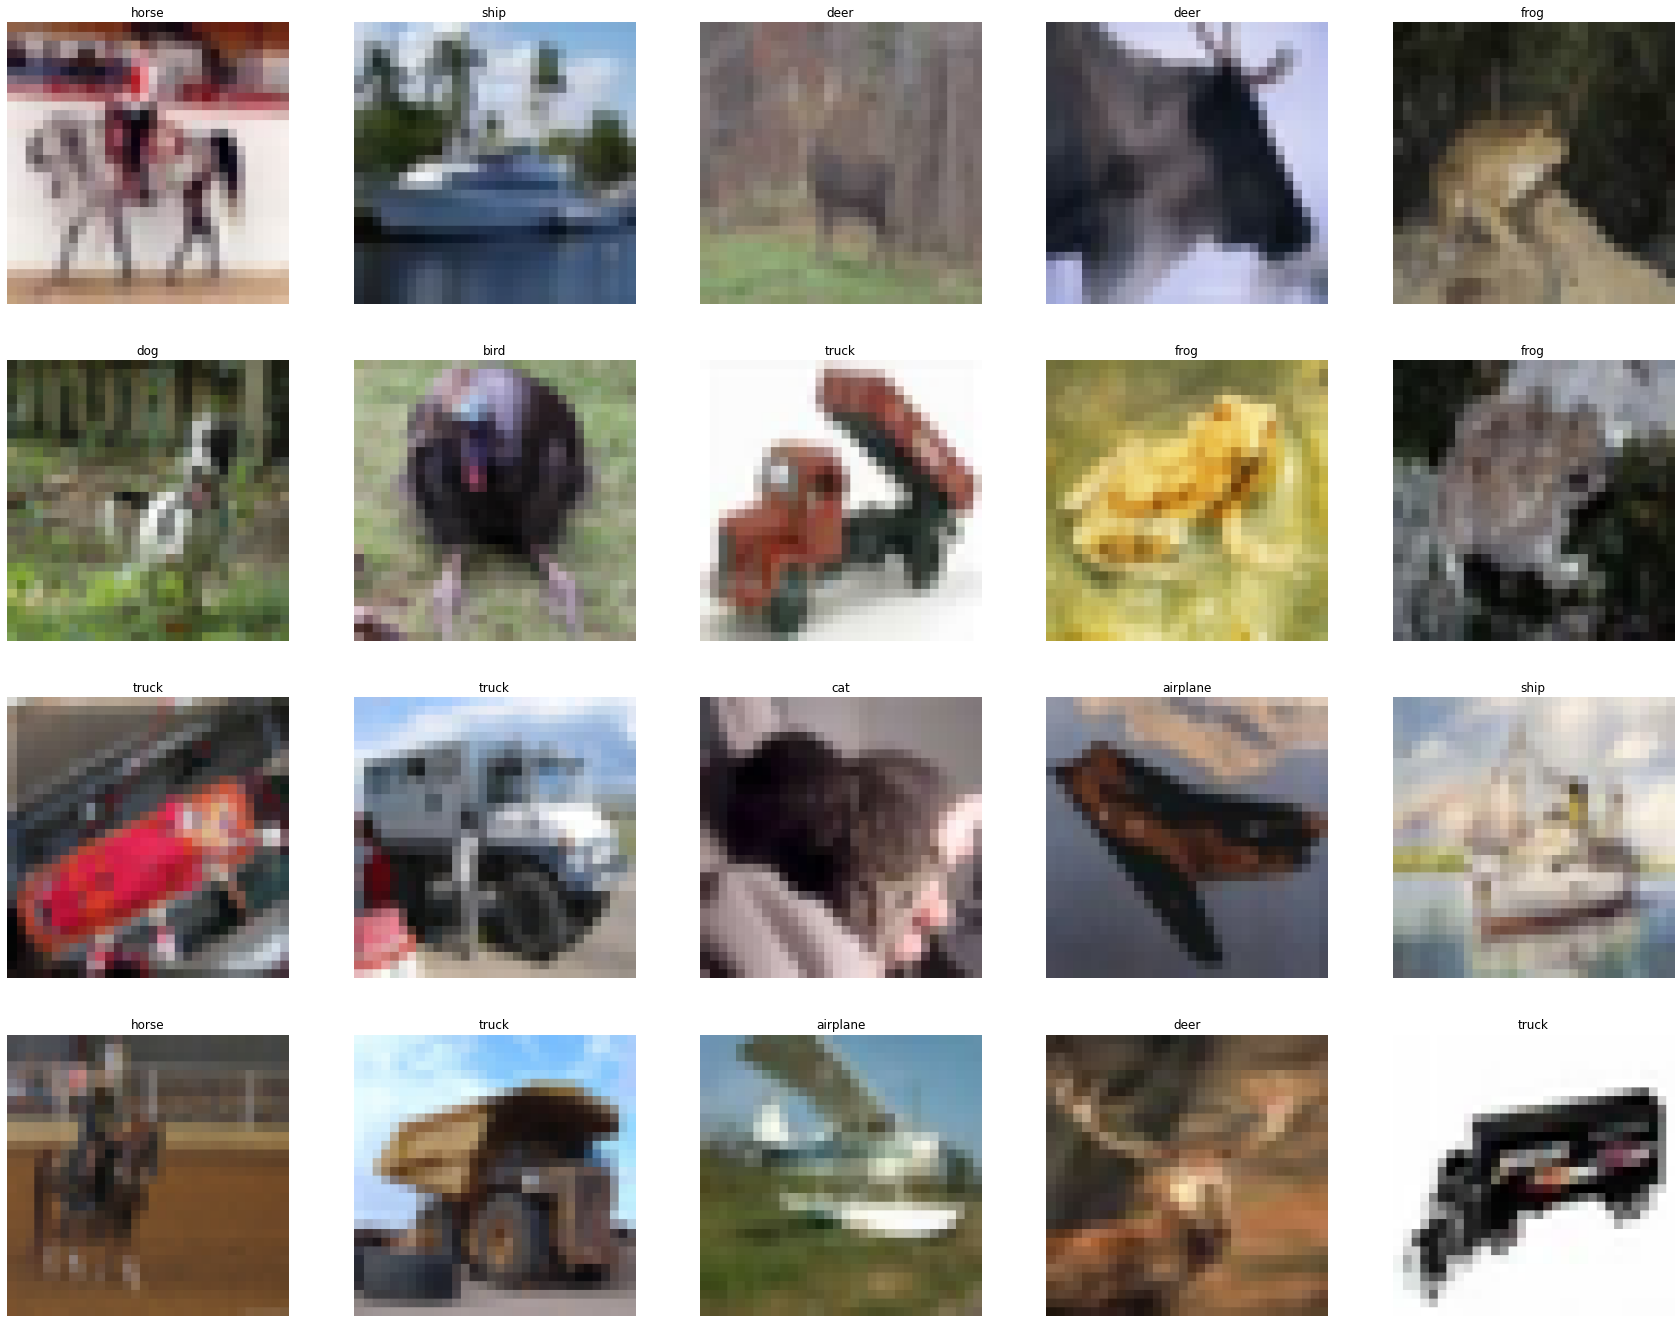

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
i=0
for k in train_ds['image'][0:20]:
    i+=1
    ax=plt.subplot(5,5,i)
    plt.imshow(k)
    plt.title(CLASS_NAMES[train_ds['label'][i-1]])
    plt.axis('off')

In [16]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [17]:
learning_rate = 0.01
momentum = 0.9

In [18]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [19]:
num_epochs = 10
batch_size = 32

train epoch: 1, loss: 1.9273, accuracy: 26.36
  test epoch: 1, loss: 1.70, accuracy: 38.12
train epoch: 2, loss: 1.4181, accuracy: 47.77
  test epoch: 2, loss: 1.27, accuracy: 54.35
train epoch: 3, loss: 1.0730, accuracy: 61.36
  test epoch: 3, loss: 0.88, accuracy: 69.05
train epoch: 4, loss: 0.8357, accuracy: 70.62
  test epoch: 4, loss: 0.81, accuracy: 71.90
train epoch: 5, loss: 0.6789, accuracy: 76.33
  test epoch: 5, loss: 0.79, accuracy: 72.91
train epoch: 6, loss: 0.5635, accuracy: 80.43
  test epoch: 6, loss: 0.71, accuracy: 76.61
train epoch: 7, loss: 0.4678, accuracy: 83.83
  test epoch: 7, loss: 0.71, accuracy: 76.32
train epoch: 8, loss: 0.3934, accuracy: 86.35
  test epoch: 8, loss: 0.64, accuracy: 79.30
train epoch: 9, loss: 0.3339, accuracy: 88.19
  test epoch: 9, loss: 0.65, accuracy: 79.92
train epoch: 10, loss: 0.2827, accuracy: 89.99
  test epoch: 10, loss: 0.62, accuracy: 81.24


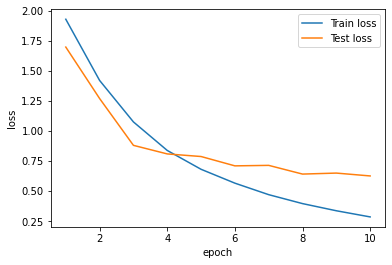

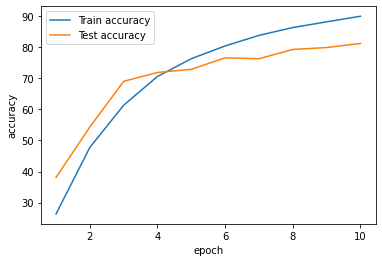

In [20]:
loss_trains = []
accuracy_trains = []
loss_tests = []
accuracy_tests = []
point_arr = []
for epoch in range(1, num_epochs+1):
    point_arr.append(epoch)
    # Use a separate PRNG key to permute image data during shuffling
    rng, input_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state = train_epoch(state, train_ds, batch_size, epoch, input_rng, loss_trains, accuracy_trains)
    
    total_loss = 0.
    sum_accuracy = 0.
    for i in range(50):
        test_mini_ds = {'image': test_ds['image'][i*200:(i+1)*200], 'label': test_ds['label'][i*200:(i+1)*200]}
        test_mini_ds['image'] = jnp.float32(test_mini_ds['image']) / 255.
        t_loss, t_accuracy = eval_model(state.params, test_mini_ds)
        total_loss += t_loss
        sum_accuracy += t_accuracy
    test_loss = total_loss/50.
    loss_tests.append(test_loss)
    test_accuracy = sum_accuracy/50.
    accuracy_tests.append(test_accuracy*100.)
    print('  test epoch: %d, loss: %.2f, accuracy: %.2f' % (epoch, test_loss, test_accuracy * 100.))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(point_arr, loss_trains, label='Train loss')
plt.plot(point_arr, loss_tests, label='Test loss')
plt.legend()
plt.show()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(point_arr, accuracy_trains, label='Train accuracy')
plt.plot(point_arr, accuracy_tests, label='Test accuracy')
plt.legend()
plt.show()